# Obtaining Data for Indian States & Italy

Available State-wise Hotspot Data: 
Delhi
Haryana
Karnataka
Kerala
Maharashtra
Punjab
Rajasthan
Tamil Nadu
Telengana
Jammu and Kashmir
Ladakh
Uttar Pradesh


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:146: RuntimeWarning: overflow encountered in exp


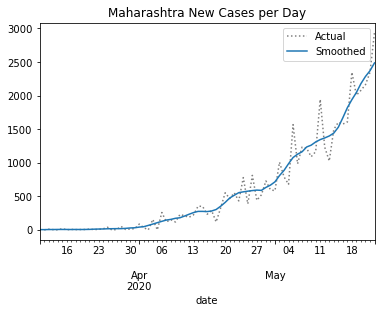

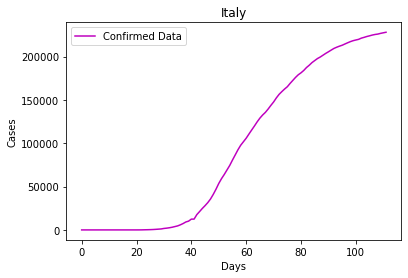

In [14]:
import pandas as pd
import numpy as np
import requests
import json

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output


import pandas as pd
import numpy as np
import requests
import json

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

from scipy import stats as sps
from scipy.interpolate import interp1d

from IPython.display import clear_output
def get_covid_india_data_api(url):
    response = requests.request("GET", url)
    return response.text.encode('utf8')

def flatten_and_parse_states_data(covid_data):
    flattened_data = []
    for day_data in covid_data:
        for region in day_data['regional']:
            flattened_data.append({
                'date' : day_data['day'],
                'state' : region['loc'],
                'case' : region['totalConfirmed']
            })
    
    states=pd.DataFrame(flattened_data)
    states.date = pd.to_datetime(states.date)
    return states

def fetch_covid_india_data(url):
    try:
        covid_data_json = get_covid_india_data_api(url)
        covid_data = json.loads(covid_data_json)['data']
        return flatten_and_parse_states_data(covid_data)
    except:
        print("API call failed")
        
#-------------------------------------------------------------------------
        
url = "https://api.rootnet.in/covid19-in/stats/history"

states_df = fetch_covid_india_data(url)

#-------------------------------------------------------------------------------------------------------
states_df = states_df[states_df.state.str.contains('#')== False]
only_state_names = pd.unique(states_df[['state']].values.ravel('K'))
only_state_names
states_df[states_df.state !='Jharkhand#']
states = states_df.set_index(['state','date']).squeeze()


#--------------------------------------------------------------------------------------------
state_name = 'Maharashtra'

def prepare_cases(cases):
    new_cases = cases.diff()

    smoothed = new_cases.rolling(7,
        win_type='gaussian',
        min_periods=1,
        center=True).mean(std=2).round()
    
    zeros = smoothed.index[smoothed.eq(0)]
    if len(zeros) == 0:
        idx_start = 0
    else:
        last_zero = zeros.max()
        idx_start = smoothed.index.get_loc(last_zero) + 1
    smoothed = smoothed.iloc[idx_start:]
    original = new_cases.loc[smoothed.index]
    
    return original, smoothed

cases = states.xs(state_name).rename(f"{state_name} cases")

original, smoothed = prepare_cases(cases)

original.plot(title=f"{state_name} New Cases per Day",
               c='k',
               linestyle=':',
               alpha=.5,
               label='Actual',
               legend=True,
             )

ax = smoothed.plot(label='Smoothed',
                   legend=True)
ax.get_figure().set_facecolor('w')

#----------------------------------------------------------------------------------------------------
TODAYS_LENGTH = len(states.xs('Maharashtra'))
all_cases_list = []
print('Available State-wise Hotspot Data: ')

for l in range(0,len(pd.unique(states_df[['state']].values.ravel('K')))-1):
    cases = states.xs(only_state_names[l]).rename(f"{only_state_names[l]} cases")
    if len(cases) == TODAYS_LENGTH:
        print(only_state_names[l])
        all_cases_list.append(cases)
#############################################################################################
from scipy.optimize import curve_fit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def predict_cases(name,days = 260, lst = True):
    if lst == True:
        for l in name:
            global_data2 = pd.read_csv("../input/novel-corona-virus-2019-dataset/covid_19_data.csv")
            country_data = global_data2[global_data2['Country/Region']==l]
            
            country_data = country_data.drop(['SNo','Province/State', 'Last Update'], axis=1)
            country_data = pd.pivot_table(country_data, values=['Confirmed', 'Recovered','Deaths'], index=['ObservationDate'], aggfunc=np.sum)
            country_data.tail()

            # we will want x_data to be the number of days since first confirmed and the y_data to be the confirmed data. This will be the data we use to fit a logistic curve
            x_data = range(len(country_data.index))
            y_data = country_data['Confirmed']
         
            
            
            def log_curve(x, k, x_0, ymax):
                return ymax / (1 + np.exp(-k*(x-x_0)))

            # Fit the curve
            popt, pcov = curve_fit(log_curve, x_data, y_data, bounds=([0,0,0],np.inf), maxfev=6000000)
            estimated_k, estimated_x_0, ymax= popt

            #print(len(country_data.index))
            # Plot the fitted curve
            k = estimated_k
            x_0 = estimated_x_0
            y_fitted = log_curve(range(0,days), k, x_0, ymax)
            #print(k, x_0, ymax)
            #print(y_fitted)
            y_data.tail()
            
            ###################################################################################################
            
            absError = abs(y_data- y_fitted[0:len(y_data)])

            SE = np.square(absError) # squared errors
            MSE = np.mean(SE) # mean squared errors
            RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
            Rsquared = 1.0 - (np.var(absError) / np.var(y_data))

          #  print()
          #  print('RMSE:', RMSE)
          #  print('R-squared:', Rsquared)

           # print()
            # Plot everything for illustration
            fig = plt.figure()
            ax = fig.add_subplot(111)
            #ax.plot(range(0,len(y_fitted)), y_fitted, '--', label='Predicted | R-squared: '+str(round(Rsquared,5)))
            ax.plot(x_data, y_data, 'm', label='Confirmed Data')
          
            ax.set_xlabel('Days') # X axis data label
            ax.set_ylabel('Cases') # Y axis data label
            ax.set_title(l)
            ax.legend(loc='upper left')
            #ax.legend('RMSE: ' + str(RMSE))
            plt.show()
        return y_data

italy_cases = predict_cases(['Italy'])

# Cleaning & Transforming Data

In [18]:
df1 = pd.read_csv('../input/india-census-yearly-data/data_2017.csv', delimiter=',')

nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')
df2 = df1.groupby('NAME').sum().reset_index()
df2 = df2.loc[:, (df2 != 0).any(axis=0)]
census_data = []
for u in all_cases_list:
    if u.name == 'Delhi cases':
        census_data.append(df2.loc[df2['NAME'] == 'New Delhi'].squeeze())
    elif u.name == 'Telengana cases':
        census_data.append(df2.loc[df2['NAME'] == 'TELANGANA'].squeeze())
    elif u.name == 'Jammu and Kashmir cases':
        census_data.append(df2.loc[df2['NAME'] == 'JAMMU & KASHMIR'].squeeze())
    

    else:
        census_data.append(df2.loc[df2['NAME'] == (u.name.replace(' cases','')).upper()].squeeze())

del all_cases_list[10]
del census_data[10]

censusDataList = []
for r in range(len(census_data)):
    br = []
    for g in census_data[r][2:]:
        br.append(g)
    censusDataList.append(np.array(br))

print('Census data has parts: ', len(census_data))
print('All case has parts: ', len(all_cases_list))

caseList = np.array(all_cases_list)

X1 = []
for b in range(len(censusDataList)):
    X1.append((censusDataList[b].tolist()))
    
X2 = np.array(X1)

X2 = np.array(X1) / np.array(X1).max(axis=0)
X3 = []
for q in X2:
    X3.append([q[:len(italy_cases)],italy_cases.to_list()/np.max(italy_cases.to_list())])
X3 = np.array(X3)
caseListNorm = []

for q in caseList:
    maxi = max(q)
    caseListNorm.append(q/maxi)
caseListNorm = np.array(caseListNorm)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (219,220,221,231,232,238,239,245,246,252,253,254,260,261,262,268,269,270,276,277,278,323,324,325,348,349,350) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


There are 1522 rows and 2537 columns
Census data has parts:  10
All case has parts:  10


# Creating Weighing Model

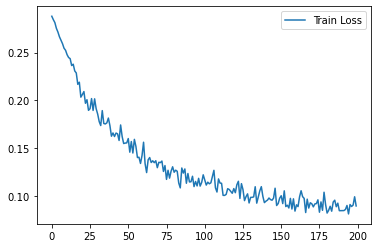

In [25]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.layers import Embedding, LSTM, Dense, Dropout, Lambda, Flatten
# design network
model = Sequential()


model.add(LSTM(300, input_shape=(X3.shape[1], X3.shape[2]), return_sequences = True))
model.add(LSTM(64, recurrent_dropout=0.4, return_sequences = True))
model.add(LSTM(32, recurrent_dropout=0.4))
model.add(Dropout(0.5))
model.add(Dense(len(caseList[0]), activation='relu'))
model.compile(loss='mae', optimizer=Adam(lr = .001))

# fit network
history = model.fit(X3[1:], caseListNorm[1:], epochs=200, batch_size=64, verbose=None, shuffle=True)
# plot history
plt.plot(history.history['loss'], label='Train Loss')
#plt.plot(history.history['accuracy'], label='Accuracy')
#pyplot.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Testing the Model

Test R-squared: 0.961009919768922


<function matplotlib.pyplot.show(*args, **kw)>

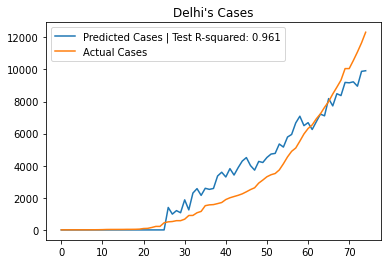

In [36]:
y_hat = model.predict(X3[0].reshape(1,2,len(italy_cases)))

absError = abs(caseListNorm[0]- y_hat)
SE = np.square(absError) # squared errors
MSE = np.mean(SE) # mean squared errors
RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
Rsquared = 1.0 - (np.var(absError) / np.var(caseListNorm[0]))

print('Test R-squared: ' + str(Rsquared))

plt.plot(y_hat[0]*max(caseList[0]), label= 'Predicted Cases | Test R-squared: ' + str(round(Rsquared,3)))
plt.plot(caseListNorm[0]*max(caseList[0]), label = 'Actual Cases')
plt.title("""Delhi's Cases""")
plt.legend()
plt.show